In [58]:
import os
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm

print("Pytorch version : %s"%(torch.__version__))

Pytorch version : 1.7.0


In [59]:
# Convert images to tensors
transform = transforms.Compose([transforms.ToTensor()])
batchsize = 10000

# Load training and testing datasets
TrainSet = datasets.MNIST(root="../downloads/MNIST", train=True, download=True, transform=transform)
TrainLoader = torch.utils.data.DataLoader(TrainSet, batch_size = batchsize, shuffle=True, num_workers=0)
TestSet = datasets.MNIST(root="../downloads/MNIST", train=False, download=True, transform=transform)
TestLoader = torch.utils.data.DataLoader(TestSet, batch_size = batchsize, shuffle=True, num_workers=0)

classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

In [60]:
print(TestSet.data.size())

torch.Size([10000, 28, 28])


In [61]:
use_gpu = torch.cuda.is_available()
if(use_gpu):
    device = "cuda"
    print(" GPU detected!")
else:
    device = "cpu"
    print(" GPU not detected")

 GPU detected!


In [70]:
class generator_net(nn.Module):
    def __init__(self, inp_dim, hidden_dim, out_dim):
        super(generator_net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(inp_dim, hidden_dim),            nn.LeakyReLU(0.2))
        self.fc2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim*2),       nn.LeakyReLU(0.2))
        self.fc3 = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim*4),     nn.LeakyReLU(0.2))
        self.fc4 = nn.Linear(hidden_dim*4, out_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return torch.tanh(x)

class discriminator_net(nn.Module):
    def __init__(self, inp_dim, hidden_dim):
        super(discriminator_net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(inp_dim, hidden_dim*4),          nn.LeakyReLU(0.2),  nn.Dropout(0.2))
        self.fc2 = nn.Sequential(nn.Linear(hidden_dim*4, hidden_dim*2),     nn.LeakyReLU(0.2),  nn.Dropout(0.2))
        self.fc3 = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim),       nn.LeakyReLU(0.2),  nn.Dropout(0.2))
        self.fc4 = nn.Linear(hidden_dim, 1)

        # self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1), nn.LeakyReLU(0.2))
        # self.conv2 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=9, kernel_size=3, padding=1), nn.LeakyReLU(0.2))
        # self.fc1   = nn.Sequential(nn.Linear(9*7*7, 50),  nn.ReLU())
        # self.fc2   = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        # x = x.view(-1, 1, 28, 28)
        # x = F.max_pool2d(self.conv1(x), 2)
        # x = F.max_pool2d(self.conv2(x), 2)
        # x = x.view(-1, 9*7*7)
        # x = self.fc1(x)
        # x = F.dropout(x, 0.2)
        # x = self.fc2(x)
        # x = F.dropout(x, 0.2)

        return torch.sigmoid(x)

In [71]:
help(F.dropout)

Help on function dropout in module torch.nn.functional:

dropout(input, p=0.5, training=True, inplace=False)
    During training, randomly zeroes some of the elements of the input
    tensor with probability :attr:`p` using samples from a Bernoulli
    distribution.
    
    See :class:`~torch.nn.Dropout` for details.
    
    Args:
        p: probability of an element to be zeroed. Default: 0.5
        training: apply dropout if is ``True``. Default: ``True``
        inplace: If set to ``True``, will do this operation in-place. Default: ``False``



In [72]:
z_dim = 100
mnist_dim = TrainSet.train_data.size(1) * TrainSet.train_data.size(2)

gen_net = generator_net(z_dim, 256, mnist_dim).to(device)
dis_net = discriminator_net(mnist_dim, 256).to(device)

/home/ashwin/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [73]:
print(gen_net)
print(dis_net)

generator_net(
  (fc1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (fc3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
discriminator_net(
  (conv1): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=441, out_features=50, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


In [79]:
criterion = nn.BCELoss()

gen_optim = optim.Adam(gen_net.parameters(), lr=1e-2)
dis_optim = optim.Adam(dis_net.parameters(), lr=1e-4)

In [80]:
def dis_train(inp):
    dis_net.zero_grad()

    num_samples = inp.shape[0]
    # Forward pass of discriminator on real data
    x_real = inp.view(-1, mnist_dim).to(device)
    y_real = torch.ones(num_samples, 1).to(device)

    out_real = dis_net(x_real)

    error_real = criterion(out_real, y_real)

    # Forward pass of discriminator on generated data
    x_gen  = gen_net(torch.randn(num_samples, z_dim).to(device))
    y_gen  = torch.zeros(num_samples, 1).to(device)

    out_gen = dis_net(x_gen)

    error_gen = criterion(out_gen, y_gen)

    dis_error = error_gen + error_real
    dis_error.backward()

    dis_optim.step()

    print(error_gen.item(), error_real.item(), dis_error.item())
    return dis_error.item()

In [81]:
def gen_train():
    gen_net.zero_grad()

    x = torch.randn(batchsize, z_dim).to(device)
    y = torch.ones(batchsize, 1).to(device)

    gen_out = gen_net(x)
    dis_out = dis_net(gen_out)

    gen_error = criterion(dis_out, y)

    gen_error.backward()
    gen_optim.step()

    return gen_error.item()

  0%|          | 0/50 [00:00<?, ?it/s]

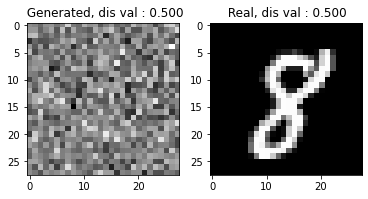

0.7615523338317871 0.6348754167556763 1.3964277505874634
0.7598766684532166 0.6350634694099426 1.3949401378631592
0.7574504613876343 0.6351511478424072 1.3926016092300415
0.7558021545410156 0.635377049446106 1.3911792039871216
0.7542425990104675 0.6353573203086853 1.3895999193191528
0.7521518468856812 0.63554847240448 1.3877003192901611
0.7504029273986816 0.6358556151390076 1.386258602142334
0.7486811876296997 0.6360790133476257 1.3847601413726807
0.746535062789917 0.636654794216156 1.3831899166107178
0.7451139688491821 0.6366676688194275 1.3817815780639648
0.7436132431030273 0.6369696259498596 1.3805828094482422
0.7417333722114563 0.6370285749435425 1.3787620067596436
0.7400091886520386 0.6377334594726562 1.3777426481246948
0.7380310893058777 0.6382125020027161 1.3762435913085938
0.736962080001831 0.6383113861083984 1.3752734661102295
0.7352048754692078 0.638863742351532 1.3740686178207397
0.7338660955429077 0.6389296054840088 1.3727957010269165
0.7322163581848145 0.6389360427856445 1

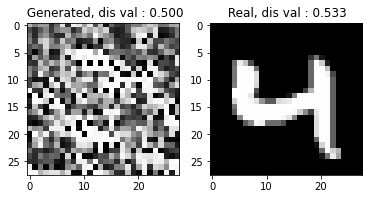

0.9491872787475586 0.6362752914428711 1.5854625701904297
0.9442862868309021 0.636891782283783 1.581178069114685
0.9406619668006897 0.6370077133178711 1.577669620513916
0.9321847558021545 0.6370841860771179 1.5692689418792725
0.9256775379180908 0.6376876831054688 1.5633652210235596
0.915440022945404 0.6388347744941711 1.5542747974395752
0.9061388373374939 0.6397912502288818 1.5459301471710205
0.8989759683609009 0.6400803327560425 1.5390563011169434
0.8874903321266174 0.6410897970199585 1.5285801887512207
0.8765736818313599 0.6420196294784546 1.5185933113098145
0.8663071990013123 0.6429213881492615 1.5092285871505737
0.8575993180274963 0.6436386704444885 1.5012379884719849
0.8462716341018677 0.6452106833457947 1.4914822578430176
0.8361241221427917 0.6462399959564209 1.4823641777038574
0.8255607485771179 0.6468298435211182 1.4723906517028809
0.8160530924797058 0.6479498147964478 1.4640028476715088
0.8070427775382996 0.6487129926681519 1.4557557106018066
0.7977275252342224 0.64984893798828

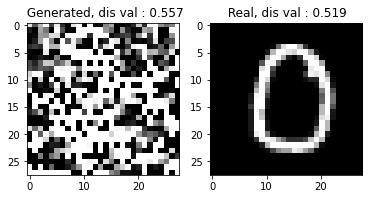

0.7908151745796204 0.662453830242157 1.4532690048217773
0.7854799628257751 0.6636782288551331 1.4491581916809082
0.7790672779083252 0.665572464466095 1.4446396827697754
0.7728017568588257 0.6666207313537598 1.4394224882125854
0.7651900053024292 0.6678373217582703 1.4330272674560547
0.7588120698928833 0.66892009973526 1.427732229232788
0.7513202428817749 0.6703771352767944 1.4216973781585693
0.7448455095291138 0.6718984246253967 1.4167439937591553
0.7386937141418457 0.6731687784194946 1.4118624925613403
0.7325543761253357 0.6744512319564819 1.4070055484771729
0.7263647317886353 0.6756289601325989 1.401993751525879
0.720012903213501 0.676584780216217 1.3965976238250732
0.714311957359314 0.6779528856277466 1.3922648429870605
0.708126425743103 0.6783812046051025 1.3865076303482056
0.7023943066596985 0.6793509125709534 1.3817452192306519
0.6969316005706787 0.6797852516174316 1.3767168521881104
0.6913941502571106 0.680631160736084 1.3720252513885498
0.6873372793197632 0.680808961391449 1.368

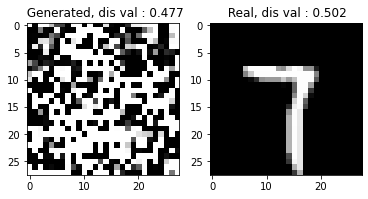

0.6598957180976868 0.6873927116394043 1.3472883701324463
0.657020092010498 0.6879400014877319 1.34496009349823
0.6536027193069458 0.6892405152320862 1.3428432941436768
0.650692880153656 0.6902221441268921 1.3409149646759033
0.6475155353546143 0.6912744045257568 1.338789939880371
0.6446152925491333 0.6922040581703186 1.3368194103240967
0.6414089798927307 0.6934348940849304 1.3348438739776611
0.6378247141838074 0.6946630477905273 1.3324878215789795
0.6332833766937256 0.6957851052284241 1.3290684223175049
0.6307855248451233 0.6970708966255188 1.327856421470642
0.6273506879806519 0.6983563899993896 1.3257070779800415
0.6228999495506287 0.6994463801383972 1.3223463296890259
0.6181240081787109 0.7010379433631897 1.3191618919372559
0.6153136491775513 0.7021315097808838 1.317445158958435
0.6128810048103333 0.7028890252113342 1.3157700300216675
0.6073350310325623 0.7047563195228577 1.31209135055542
  6%|▌         | 3/50 [02:02<31:53, 40.71s/it]


KeyboardInterrupt: 

In [77]:
iterations = 50
dis_factor = 5      # Number of times discriminator is trained than the generator

num_batch  = TrainSet.data.size()[0] // batchsize

debug = True

idx = 0

gen_hist = []
dis_hist = []

for epoch in tqdm(range(iterations)):
    gen_runningloss = 0
    dis_runningloss = 0

    if(debug):
        gen_inp  = torch.randn(1, z_dim).to(device)
        real_img = (list(TrainLoader)[0])[0].view(-1, 28*28)[0].to(device)
        gen_img  = gen_net(gen_inp)

        dis_gout = dis_net(gen_img).cpu()
        dis_rout = dis_net(real_img).cpu()

        plt.subplot(121)
        plt.imshow(gen_img.cpu().detach().view(28,28).numpy(), cmap='gray')
        plt.title(" Generated, dis val : %.3f"%(dis_gout))

        plt.subplot(122)
        plt.imshow(real_img.cpu().detach().view(28,28).numpy(), cmap='gray')
        plt.title(" Real, dis val : %.3f"%(dis_rout))

        plt.show()

    for i in range(dis_factor):
        if(i != 0 and dis_runningloss < 0.5):
            break
        for data in TrainLoader:
            inputs, data = data

            dis_loss = dis_train(inputs)

            dis_runningloss += dis_loss
            dis_hist.append((idx, dis_loss))

            idx

    for i in range(num_batch):
        gen_loss = gen_train()

        gen_runningloss += gen_loss
        gen_hist.append((idx, gen_loss))

        idx += 1

    gen_runningloss /= num_batch
    dis_runningloss /= (num_batch * dis_factor)
        
    if(debug):
       print(" Gen loss : %5.1f, Dis loss : %5.1f"%(gen_runningloss, dis_runningloss))
     
    if(epoch % 10 == 9):        
        print(" Iteration %3d/%3d, gen loss %15.1f, disloss %.1f"%(epoch+1, iterations, gen_runningloss, dis_runningloss))

print(" Finished training")

In [ ]:
plt.plot(list(zip(*gen_hist))[0], list(zip(*gen_hist))[1], label="Generator")
plt.plot(list(zip(*dis_hist))[0], list(zip(*dis_hist))[1], label="Discriminator")
plt.legend()
plt.show()

In [ ]:
for i in range(10):
    gen_inp = torch.randn(1, z_dim).to(device)
    gen_out = gen_net(gen_inp)

    plt.imshow(gen_out.cpu().view(28, 28).detach().numpy(), cmap='gray')
    plt.title(" Generated image")
    plt.show()